# Quality Control prediction for incoming goods.
    
### **Grzegorz Kowalczyk**
#### 01/03/2024

* **1 Introduction**
* **2 Load and check data**
    * 2.1 Load data
    * 2.2 Data dictionary
    * 2.3 Data types, empty strings
    * 2.4 Null and missing values
    * 2.5 Data distribution
* **3 Data preprocessing**
    * 3.1 Data cleaning
* **4 Filling missing Values**
    * 4.1 Age
* **5 Outlier detection??**      
* **6 Feature analysis**
    * 5.1 Numerical values
    * 5.2 Categorical values

* **7 Feature engineering**
    * 6.1
    * 6.2
    * 6.3 
    * 6.4 
 
* **8 Scaling**
  
* **9 Modeling**
    * 6.1 Simple modeling
        * 6.1.1 Cross validate models
        * 6.1.2 Hyperparamater tunning for best models
        * 6.1.3 Plot learning curves
        * 6.1.4 Feature importance of the tree based classifiers
    * 6.2 Ensemble modeling
        * 6.2.1 Combining models
    * 6.3 Prediction
        * 6.3.1 Predict and Submit results

## 1. Introduction

In the context of mid-sized manufacturing enterprises, factories often engage in the production of a multitude of products, necessitating the procurement of numerous parts and components from a diverse array of international suppliers, often employing dual sourcing strategies.

This project endeavors to develop a predictive model, leveraging real-world production data, specifically focusing on aluminum LED profiles manufacturing, with the objective of accurately classifying incoming goods as either 'OK' or 'NOK' (not OK).

A robust working model, enhanced with additional refinements, holds the potential to provide valuable insights not only to quality assurance personnel but also to logistics professionals, aiding in supplier selection processes. Moreover, it can serve as a tool for research and development teams, facilitating the identification of product features during the design phase that mitigate the likelihood of faulty deliveries.


In [1231]:
import pandas as pd
# pd.set_option('display.max_rows', None)
import numpy as np
import regex as re
from datetime import datetime, timedelta
from random import randint
import missingno
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from collections import Counter
warnings.filterwarnings("ignore")
pd.options.display.float_format = '{:.2f}'.format
# !pip install openpyxl
# !pip install regex

## 2. Load and check data

### 2.1 load data

In [1232]:
df = pd.read_excel('../Github depo/QC_encoded_data.xlsx')

In [1233]:
df.head()

,date,finish,delivered_pcs_pack,pack_weight_kg,OK_NOK,pcs_lenght_mm,quantity_pcs,overal_weight_kg,pcs_pck,name_e,drawing_no_e,shape_no_e,supplier_e
0,"13,01,2017",C-0,NaN,NaN,NOK,NaN,NaN,NaN,40.00,Regor,DR0,SH0,SU0
1,"13,01,2017",C-0,NaN,NaN,NOK,NaN,NaN,NaN,40.00,Procyon,DR1,SH1,SU0
2,"13,01,2017",C-0,NaN,NaN,NOK,NaN,NaN,NaN,40.00,Regor,DR0,SH0,SU0
3,"13,01,2017",C-0,NaN,NaN,NOK,NaN,NaN,NaN,40.00,Regor,DR0,SH0,SU0
4,"19,01,2017",C-0,NaN,NaN,NOK,NaN,NaN,NaN,40.00,Grus,DR2,SH2,SU1


In [1234]:
df.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6448 entries, 0 to 6447
Data columns (total 13 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   date                6403 non-null   object 
 1   finish              6448 non-null   object 
 2   delivered_pcs_pack  4807 non-null   object 
 3   pack_weight_kg      2411 non-null   object 
 4   OK_NOK              6448 non-null   object 
 5   pcs_lenght_mm       4514 non-null   float64
 6   quantity_pcs        4514 non-null   object 
 7   overal_weight_kg    4488 non-null   float64
 8   pcs_pck             6350 non-null   float64
 9   name_e              6448 non-null   object 
 10  drawing_no_e        6448 non-null   object 
 11  shape_no_e          6448 non-null   object 
 12  supplier_e          6448 non-null   object 
dtypes: float64(3), object(10)
memory usage: 3.4 MB


Reorder the columns

In [1235]:
new_order = ['OK_NOK','date', 'name_e', 'shape_no_e', 'drawing_no_e', 'finish', 'supplier_e', 'pcs_pck','delivered_pcs_pack', 'pack_weight_kg', 
       'pcs_lenght_mm', 'quantity_pcs', 'overal_weight_kg']

In [1236]:
df = df[new_order]

In [1237]:
df = df.rename(columns={'name_e' : 'name', 'shape_no_e' : 'shape_no', 'drawing_no_e': 'drawing_no', 'supplier_e': 'supplier', 'finish': 'surface_finish'})

In [1238]:
df.head()

,OK_NOK,date,name,shape_no,drawing_no,surface_finish,supplier,pcs_pck,delivered_pcs_pack,pack_weight_kg,pcs_lenght_mm,quantity_pcs,overal_weight_kg
0,NOK,"13,01,2017",Regor,SH0,DR0,C-0,SU0,40.00,NaN,NaN,NaN,NaN,NaN
1,NOK,"13,01,2017",Procyon,SH1,DR1,C-0,SU0,40.00,NaN,NaN,NaN,NaN,NaN
2,NOK,"13,01,2017",Regor,SH0,DR0,C-0,SU0,40.00,NaN,NaN,NaN,NaN,NaN
3,NOK,"13,01,2017",Regor,SH0,DR0,C-0,SU0,40.00,NaN,NaN,NaN,NaN,NaN
4,NOK,"19,01,2017",Grus,SH2,DR2,C-0,SU1,40.00,NaN,NaN,NaN,NaN,NaN


In [1239]:
df.describe()

,pcs_pck,pcs_lenght_mm,overal_weight_kg
count,6350.00,4514.00,4488.00
mean,38.54,4078.38,438.28
std,22.97,227.00,226.47
min,2.00,1500.00,0.00
25%,20.00,4050.00,258.39
50%,40.00,4150.00,450.36
75%,40.00,4150.00,568.22
max,100.00,5100.00,1702.41


Describe function shows only 3 columns which means only those 3 are numeric, I will address this issue later on.

## 2.2 Data dictionary

* 0.   **OK_NOK**:
      This column contains a target label   
* 1.   **date**:
      Date of delivery
* 2.   **name**:
      This column consist of aluminum profile names
* 3.   **shape_no**:
      Number that defines shape of the aluminium profile.
      Shape itself dosn't describe the final product because many suppliers can deliver the same shape in many colours and at different lenghts
* 4.   **drawing_no**:
      Describes a shape and supplier but dosn't contain information about colours and different lenghts
* 5.   **surface_finish**:
      Information about the colour of the profile
* 6.   **supplier**:
      Name of the supplier
* 7.   **pcs_pck**:
      Number of aluminium profiles that should be delivered in one package
* 8.   **delivered_pcs_pack**:
      Number of aluminium profiles that ware delivered in one package
* 9.   **pack_weight_kg**:
      Weight of one package
* 10.  **pcs_lenght_mm**:
      Lenght of the aluminium profiles
* 11.  **quantity_pcs**:
      How many pcs where delivered 
* 12.  **overal_weight_kg**:
      The overal weight delivered profiles

## 2.3 Data types, empty strings

**Comment**: Since our target is binary classification we can map OK = 1 and NOK = 0

In [1240]:
df['OK_NOK'] = df['OK_NOK'].map({'OK': 1, 'NOK': 0})

In [1241]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6448 entries, 0 to 6447
Data columns (total 13 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   OK_NOK              6448 non-null   int64  
 1   date                6403 non-null   object 
 2   name                6448 non-null   object 
 3   shape_no            6448 non-null   object 
 4   drawing_no          6448 non-null   object 
 5   surface_finish      6448 non-null   object 
 6   supplier            6448 non-null   object 
 7   pcs_pck             6350 non-null   float64
 8   delivered_pcs_pack  4807 non-null   object 
 9   pack_weight_kg      2411 non-null   object 
 10  pcs_lenght_mm       4514 non-null   float64
 11  quantity_pcs        4514 non-null   object 
 12  overal_weight_kg    4488 non-null   float64
dtypes: float64(3), int64(1), object(9)
memory usage: 655.0+ KB


**Comment**: The columns:
* 'delivered_pcs_pack',
* 'pack_weight_kg',
* 'quantity_pcs'
  
   are mix of strings, numeric and nans that I need to handle first.

* **delivered_pcs_pack'**

In [1242]:
delivered_pcs_vc = df['delivered_pcs_pack'].value_counts(dropna=False)


In [1243]:
# Change the type of whole column to str

df['delivered_pcs_pack'] = df['delivered_pcs_pack'].astype(str)

# Filter out rows containing '40 / 60'
filtered_df = df[df['delivered_pcs_pack'].str.contains('40 / 60')]


In [1244]:
#  Replace values, strip white spaces:

df['delivered_pcs_pack'] = df['delivered_pcs_pack'].replace(['20 SZT', 'BRAK', '-', '0', '40 / 60'], ['20', 'np.nan', 'np.nan', 'np.nan', '40']).str.strip()

# Change the whole column back to numeric

df['delivered_pcs_pack'] = pd.to_numeric(df['delivered_pcs_pack'], errors='coerce')


* **pack_weight_kg**

In [1245]:
# Check for strings, nan etc, then convert to nummeric.
pack_weight_kg_vc = df['pack_weight_kg'].value_counts(dropna=False)
filtered_pack_weight_kg_vc = pack_weight_kg_vc[pack_weight_kg_vc<2]


In [1246]:
df['pack_weight_kg'] =  pd.to_numeric(df['pack_weight_kg'], errors='coerce')
df['pack_weight_kg'] = df['pack_weight_kg'].round(decimals=1)
df['pack_weight_kg'].value_counts(dropna=False).index

Index([  nan,  27.0,  32.2,  21.4,  22.7,  31.3,  25.4,  19.4,  27.1,  32.0,
       ...
        40.6,  40.7,  34.4,  43.5,  55.0,  39.5,  48.5, 350.0,  18.5,  12.2],
      dtype='float64', name='pack_weight_kg', length=259)

* **quantity_pcs**

In [1247]:
quantity_pcs_vc = df['quantity_pcs'].value_counts(dropna=False)

In [1248]:
df['quantity_pcs'] = pd.to_numeric(df['quantity_pcs'], errors='coerce')

In [1249]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6448 entries, 0 to 6447
Data columns (total 13 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   OK_NOK              6448 non-null   int64  
 1   date                6403 non-null   object 
 2   name                6448 non-null   object 
 3   shape_no            6448 non-null   object 
 4   drawing_no          6448 non-null   object 
 5   surface_finish      6448 non-null   object 
 6   supplier            6448 non-null   object 
 7   pcs_pck             6350 non-null   float64
 8   delivered_pcs_pack  4801 non-null   float64
 9   pack_weight_kg      2405 non-null   float64
 10  pcs_lenght_mm       4514 non-null   float64
 11  quantity_pcs        4513 non-null   float64
 12  overal_weight_kg    4488 non-null   float64
dtypes: float64(6), int64(1), object(6)
memory usage: 655.0+ KB


In [1250]:
df.describe()

,OK_NOK,pcs_pck,delivered_pcs_pack,pack_weight_kg,pcs_lenght_mm,quantity_pcs,overal_weight_kg
count,6448.00,6350.00,4801.00,2405.00,4514.00,4513.00,4488.00
mean,0.81,38.54,38.57,27.55,4078.38,705.67,438.28
std,0.39,22.97,22.79,10.22,227.00,591.61,226.47
min,0.00,2.00,0.25,0.00,1500.00,0.00,0.00
25%,1.00,20.00,20.00,22.10,4050.00,260.00,258.39
50%,1.00,40.00,40.00,27.00,4150.00,525.00,450.36
75%,1.00,40.00,40.00,32.20,4150.00,1000.00,568.22
max,1.00,100.00,250.00,350.00,5100.00,5200.00,1702.41


#### 2.4 Null and missing values

In [1251]:
df.isnull().sum().sort_values(ascending=False)

pack_weight_kg        4043
overal_weight_kg      1960
quantity_pcs          1935
pcs_lenght_mm         1934
delivered_pcs_pack    1647
pcs_pck                 98
date                    45
OK_NOK                   0
name                     0
shape_no                 0
drawing_no               0
surface_finish           0
supplier                 0
dtype: int64

<Axes: >

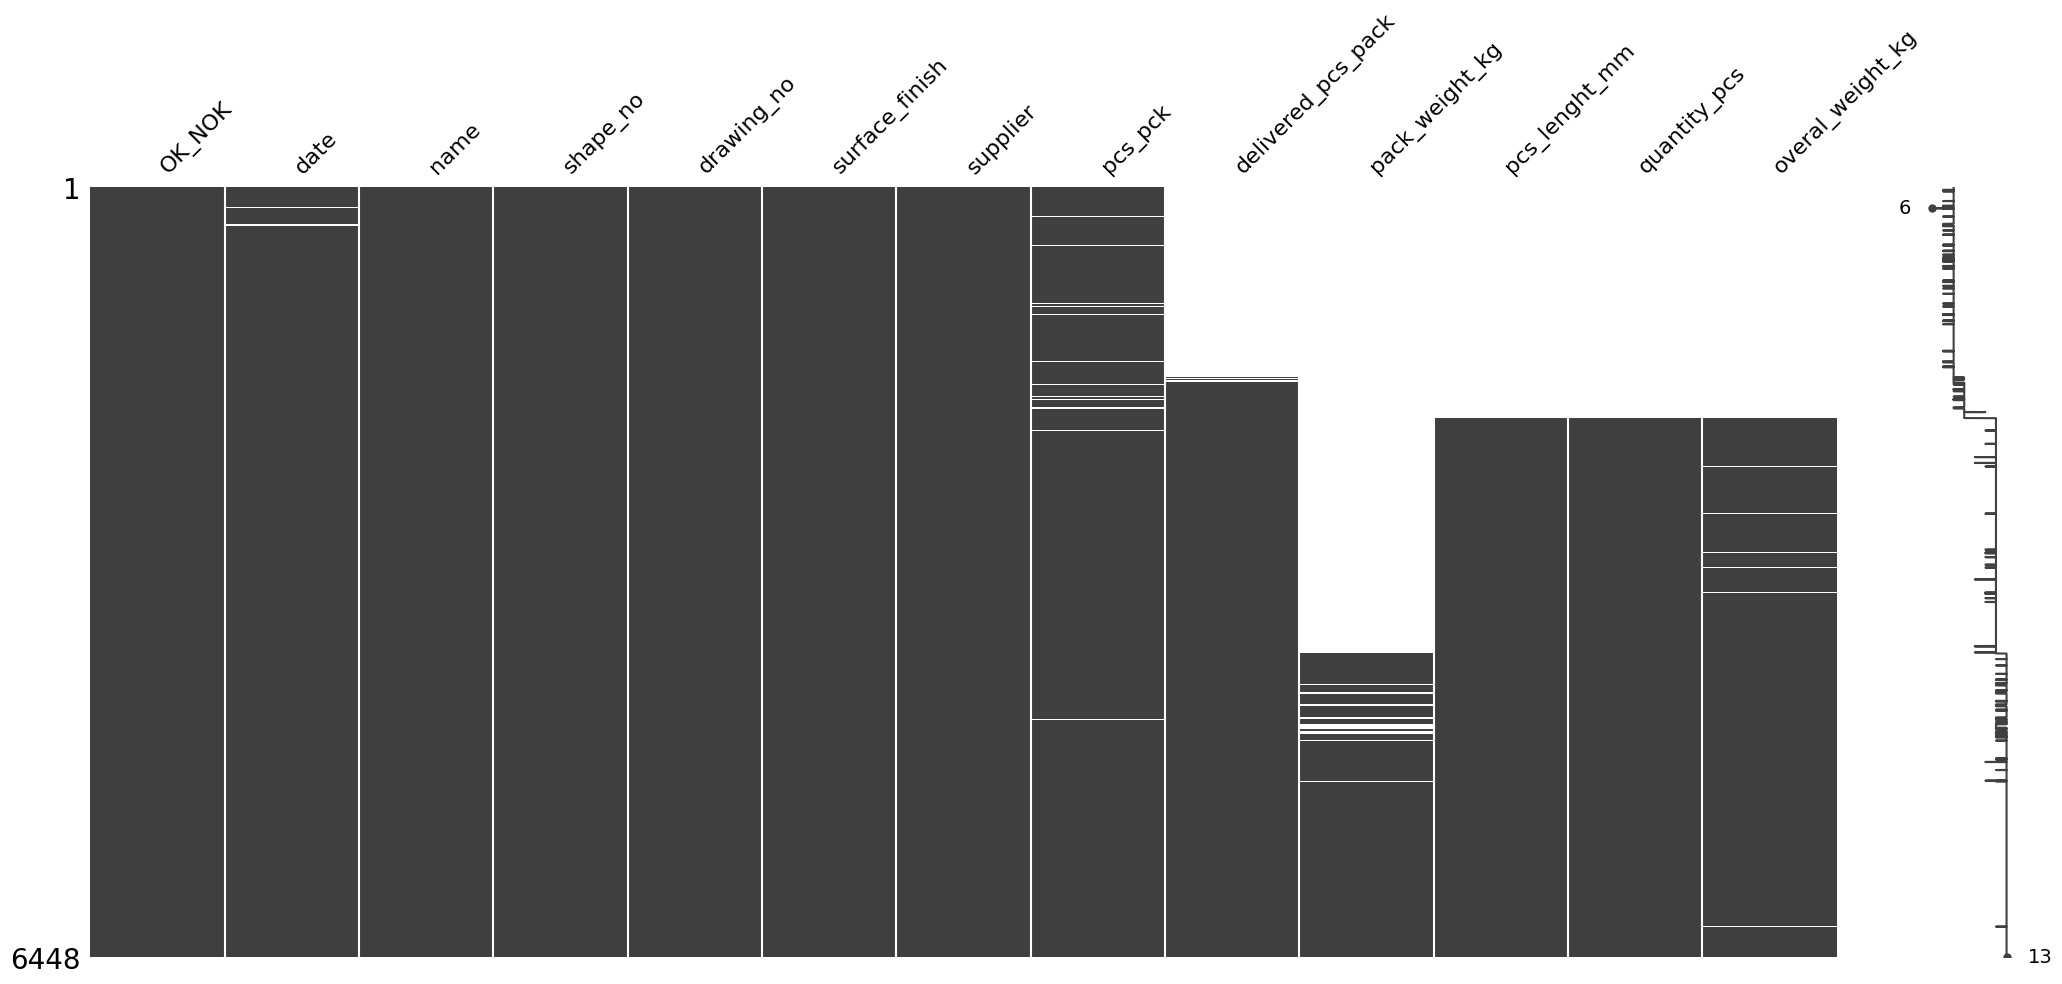

In [1252]:
missingno.matrix(df)

<Axes: >

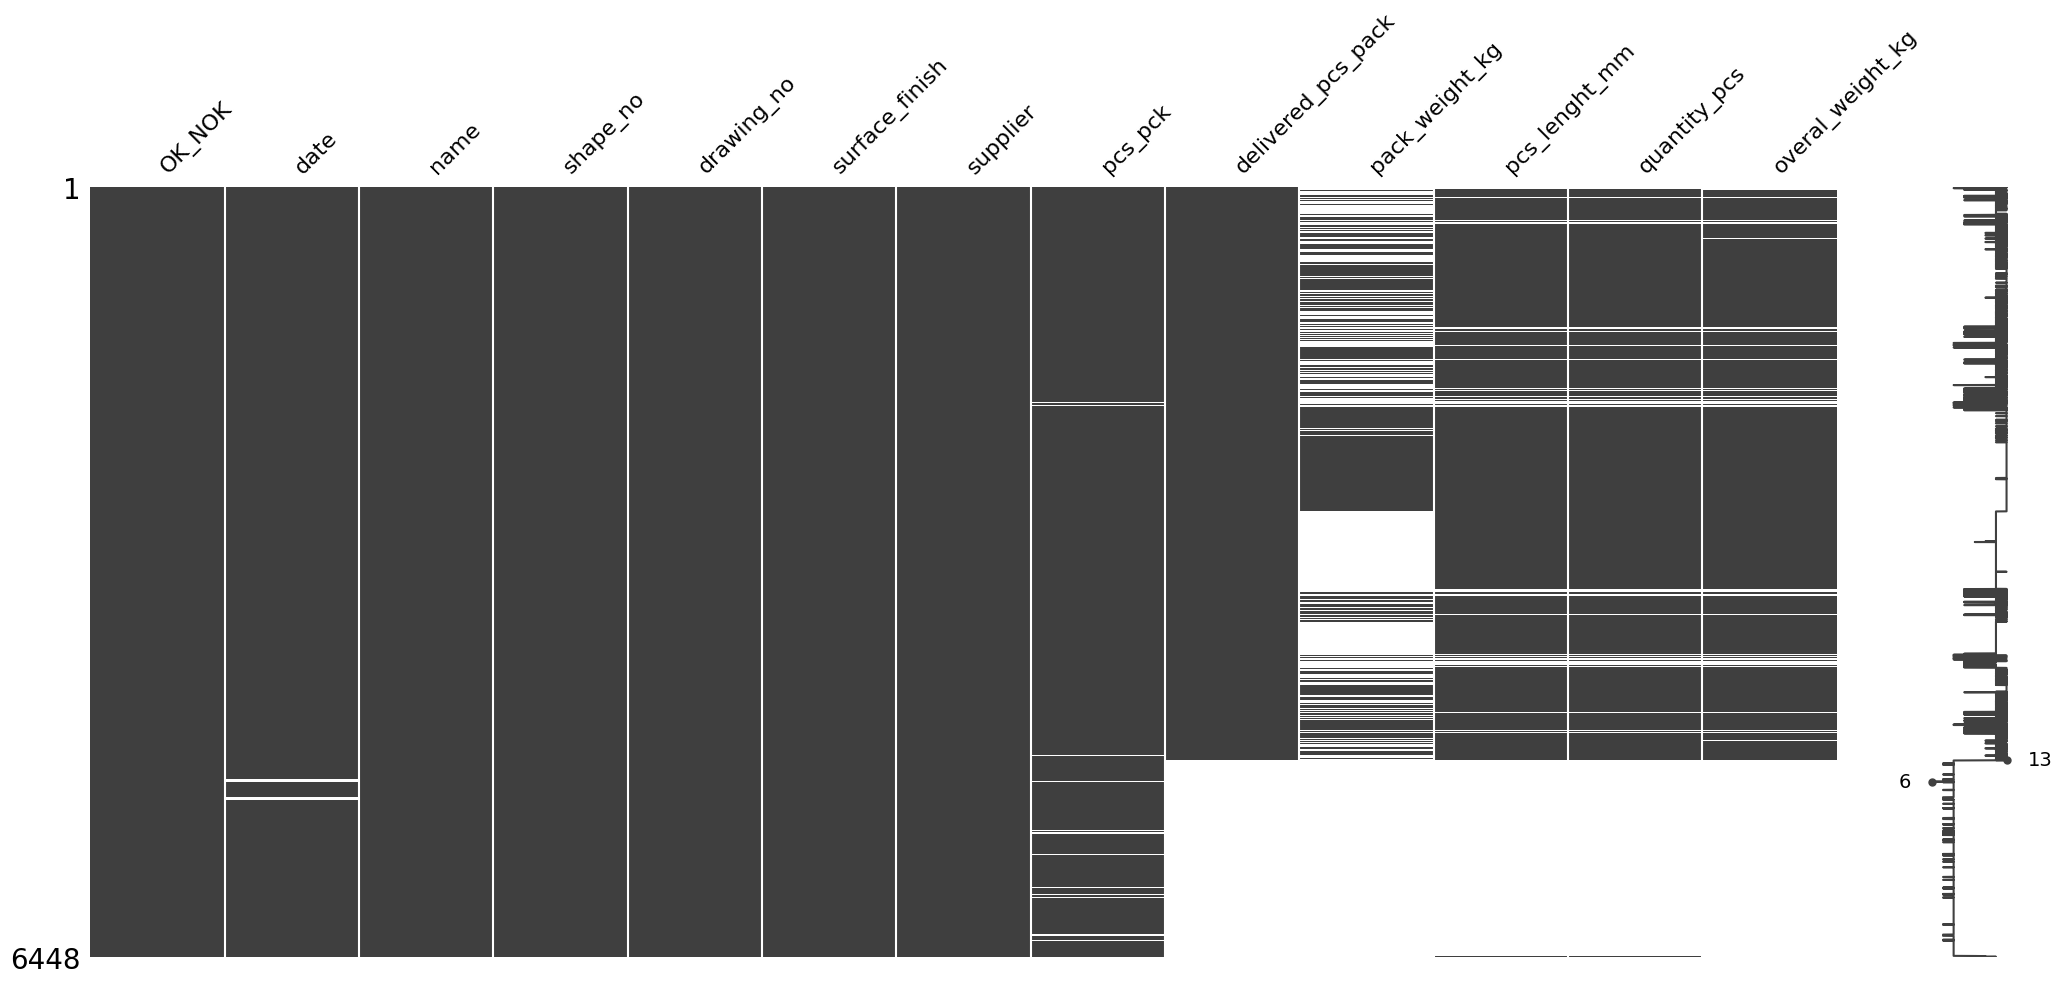

In [1253]:
sorted_delivered_pcs_pack = df.sort_values('delivered_pcs_pack')
missingno.matrix(sorted_delivered_pcs_pack)

### 2.5 Data distribution

**Comment**: Since the data is about the delivery of goods some products will be delivered more frequent than others. Let's check how the products are represented in the dataset by using seaborn count plot.

In [1254]:
# filtering a list of unique deliveries.
vc_combo = df[['drawing_no', 'surface_finish','name']].apply(tuple, axis=1).value_counts()
vc_combo

(DR5, C-0, Phecda)          270
(DR1, C-0, Procyon)         250
(DR0, C-0, Regor)           237
(DR10, C-0, Phecda)         234
(DR20, C-0, Procyon)        205
                           ... 
(DR113, SUR, Shaula)          1
(DR112, SUR, Capricorn)       1
(DR169, C-0, Izar)            1
(DR170, SUR, Jupiter)         1
(DR143, C-35, Andromeda)      1
Name: count, Length: 352, dtype: int64

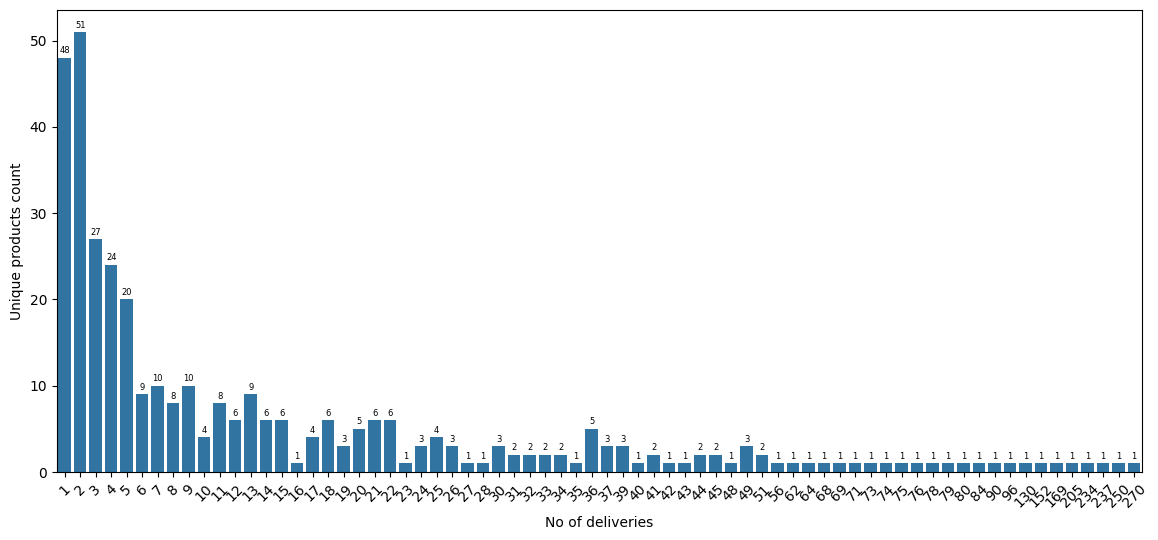

In [1255]:
plt.figure(figsize=(14, 6))
ax = sns.countplot(data=df, x=vc_combo)
plt.xlabel('No of deliveries')
plt.ylabel('Unique products count')
plt.xticks(rotation=45);


for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', fontsize=6, color='black', xytext=(0, 5),
                textcoords='offset points')
plt.show()

**Comment**:

Observation: There appears to be a substantial cluster of unique deliveries with occurrences of less than 10. Various factors could contribute to this phenomenon, including the introduction of new products, low sales volume items, sporadic deliveries from suppliers (e.g., cargo shipping), or discontinued relationships with underperforming suppliers. A critical inference drawn from this observation is that predictive modeling based on such sparse data instances may yield unreliable results.

Recommendation: In the subsequent modeling phase of this project, it is advisable to filter out products with fewer than 5 deliveries. This strategic approach aims to enhance the robustness of the model by focusing on more representative data points. Additionally, this filtering criterion should undergo thorough validation during model evaluation to ensure its effectiveness in improving predictive accuracy and generalizability.

**Comment:** There is at least 150 unique products that we wont be able to predict. Now let's check class distribution.

In [1256]:
ok_nok_vc = df['OK_NOK'].value_counts()
percentage_0 = ok_nok_vc[0] / ok_nok_vc.sum() * 100
percentage_1 = ok_nok_vc[1] / ok_nok_vc.sum() * 100

print(f"Percentage of class 0: {percentage_0:.2f}%")
print(f"Percentage of class 1: {percentage_1:.2f}%")

Percentage of class 0: 18.98%
Percentage of class 1: 81.02%


**Comment:** 

Observation: The dataset reveals a substantial class imbalance, with Class 1 being approximately 5 times more represented than Class 0. This observation aligns with business realities, as an equal distribution of NOK (Not OK) deliveries would impede operational efficiency. However, the presence of 18% NOK deliveries signifies significant room for improvement in the delivery process.

Recommendation: Addressing the high percentage of NOK deliveries presents an opportunity to enhance overall performance and customer satisfaction. Implementing strategies to reduce NOK occurrences, such as refining quality control measures, optimizing supplier relationships, and enhancing delivery logistics, can lead to substantial improvements in business outcomes and stakeholder satisfaction.

### 3. Data preprocesing

### 3.1 Data cleaning - date column

**Comment**: Before proceeding with datetime conversion, it's essential to inspect the 'Date' column values to assess the variety of formats present, likely due to manual entry by QC personnel over the years. This initial exploration will provide insights into the range of formats and values encountered, facilitating the development of an appropriate cleaning strategy.

In [1257]:
df['date'].apply(type).nunique()

3

In [1258]:
df['date'].apply(type).value_counts()

date
<class 'datetime.datetime'>    4621
<class 'str'>                  1782
<class 'float'>                  45
Name: count, dtype: int64

In [1259]:
df.head(2)

,OK_NOK,date,name,shape_no,drawing_no,surface_finish,supplier,pcs_pck,delivered_pcs_pack,pack_weight_kg,pcs_lenght_mm,quantity_pcs,overal_weight_kg
0,0,"13,01,2017",Regor,SH0,DR0,C-0,SU0,40.00,NaN,NaN,NaN,NaN,NaN
1,0,"13,01,2017",Procyon,SH1,DR1,C-0,SU0,40.00,NaN,NaN,NaN,NaN,NaN


In [1260]:
df.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6448 entries, 0 to 6447
Data columns (total 13 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   OK_NOK              6448 non-null   int64  
 1   date                6403 non-null   object 
 2   name                6448 non-null   object 
 3   shape_no            6448 non-null   object 
 4   drawing_no          6448 non-null   object 
 5   surface_finish      6448 non-null   object 
 6   supplier            6448 non-null   object 
 7   pcs_pck             6350 non-null   float64
 8   delivered_pcs_pack  4801 non-null   float64
 9   pack_weight_kg      2405 non-null   float64
 10  pcs_lenght_mm       4514 non-null   float64
 11  quantity_pcs        4513 non-null   float64
 12  overal_weight_kg    4488 non-null   float64
dtypes: float64(6), int64(1), object(6)
memory usage: 2.6 MB


**Comment**: Let's check last entry, and NaN values:

In [1261]:
df.date.iloc[-1]

datetime.datetime(2022, 9, 13, 0, 0)

In [1262]:
df.date.isnull().sum()

45

**Comment**: Now I will create new column to check if there are any strings present in date column:

In [1263]:
df['is_str'] = df.date.apply(lambda x: True if isinstance(x, str) else False)

In [1264]:
df['is_str'].value_counts()

is_str
False    4666
True     1782
Name: count, dtype: int64

**Comment**: As Expected nearly 1,8k rows are strings, lets move the column closer to date column to have a better view, and let's see if those strings contain any letters.

In [1265]:
df.insert(2, 'is_str', df.pop('is_str'))


In [1266]:
letter_pattern = re.compile(r"[a-zA-Z]")

In [1267]:
filter_letter_pattern = df.loc[df['is_str']==True, 'date'].apply(lambda x: True if letter_pattern.search(x) else False)

In [1268]:
len(filter_letter_pattern[filter_letter_pattern].index)

54

**Comment**: Out of all elements from date column that are strings 54 contain letters, which isnt that bad considering 1,8k strings.
My approach is to focus on strings that are not letters and try to convert those in to proper datetime format.
I will create new column date_fmt and I will use it to perform all operations there without risking loosing any valid data.

In [1269]:
df.loc[df['is_str']==True,'date_fmt'] = df.loc[df['is_str']==True,'date']

In [1270]:
df.insert(2, 'date_fmt', df.pop('date_fmt'))

In [1271]:
df['date_fmt'] = df.loc[df['is_str']==True,'date_fmt'].str.replace(',', '.').str.replace('/', '.')

In [1272]:
df

,OK_NOK,date,date_fmt,is_str,name,shape_no,drawing_no,surface_finish,supplier,pcs_pck,delivered_pcs_pack,pack_weight_kg,pcs_lenght_mm,quantity_pcs,overal_weight_kg
0,0,"13,01,2017",13.01.2017,True,Regor,SH0,DR0,C-0,SU0,40.00,NaN,NaN,NaN,NaN,NaN
1,0,"13,01,2017",13.01.2017,True,Procyon,SH1,DR1,C-0,SU0,40.00,NaN,NaN,NaN,NaN,NaN
2,0,"13,01,2017",13.01.2017,True,Regor,SH0,DR0,C-0,SU0,40.00,NaN,NaN,NaN,NaN,NaN
3,0,"13,01,2017",13.01.2017,True,Regor,SH0,DR0,C-0,SU0,40.00,NaN,NaN,NaN,NaN,NaN
4,0,"19,01,2017",19.01.2017,True,Grus,SH2,DR2,C-0,SU1,40.00,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6443,1,2022-09-13 00:00:00,NaN,False,Voyager,SH82,DR111,C-0,SU1,100.00,100.00,38.20,4150.00,900.00,343.62
6444,1,2022-09-13 00:00:00,NaN,False,Voyager,SH82,DR111,C-0,SU1,100.00,100.00,38.20,4150.00,920.00,351.26
6445,1,2022-09-13 00:00:00,NaN,False,Aludra,SH10,DR11,SUR,SU1,60.00,40.00,12.20,4050.00,1590.00,482.96
6446,1,2022-09-13 00:00:00,NaN,False,Wasat,SH15,DR16,SUR,SU1,100.00,40.00,10.50,4050.00,2032.00,534.92


In [1273]:
df['date_fmt'] = pd.to_datetime(df['date_fmt'], format='%d.%m.%Y', errors='coerce')

In [1274]:
df['date_fmt'] = df['date_fmt'].dt.strftime('%Y-%m-%d %H:%M:%S')

**Comment**: Now I will copy over from date column the data that are not strings and convert them to datetime.

In [1275]:
df.loc[df['is_str']==False, 'date_fmt'] = pd.to_datetime(df.loc[df['is_str']==False, 'date'], format='%Y-%m-%d %H:%M:%S')

In [1276]:
df['date_fmt'] = pd.to_datetime(df['date_fmt'], format='%Y-%m-%d %H:%M:%S', errors='coerce')

**Comment**: After successfully converting the majority of the data to datetime format, the next step involves addressing the remaining NaT (Not a Time) values.

In [1277]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6448 entries, 0 to 6447
Data columns (total 15 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   OK_NOK              6448 non-null   int64         
 1   date                6403 non-null   object        
 2   date_fmt            6345 non-null   datetime64[ns]
 3   is_str              6448 non-null   bool          
 4   name                6448 non-null   object        
 5   shape_no            6448 non-null   object        
 6   drawing_no          6448 non-null   object        
 7   surface_finish      6448 non-null   object        
 8   supplier            6448 non-null   object        
 9   pcs_pck             6350 non-null   float64       
 10  delivered_pcs_pack  4801 non-null   float64       
 11  pack_weight_kg      2405 non-null   float64       
 12  pcs_lenght_mm       4514 non-null   float64       
 13  quantity_pcs        4513 non-null   float64     

**Comment**: I've opted to manually inspect all remaining NaT (Not a Time) values to retrieve any salvageable data.

In [1278]:
original_max_rows = pd.options.display.max_rows

# Temporarily set display options to show all rows
pd.options.display.max_rows = None

# Run the query
result = df.query('date_fmt.isnull()')
# result

In [1279]:
df.loc[72, 'date_fmt'] = '2016.10.12'
df.loc[74, 'date_fmt'] = '2016.10.10'
df.loc[233, 'date_fmt'] = '2016.10.12'
df.loc[426, 'date_fmt'] = '2016.03.28'
df.loc[894, 'date_fmt'] = '2018.02.21'
df.loc[1532, 'date_fmt'] = '2018.09.12'
df.loc[1777, 'date_fmt'] = '2018.11.21'
df.loc[1908, 'date_fmt'] = '2018.12.12'

In [1280]:
df['date_fmt'] = pd.to_datetime(df['date_fmt'], format='%Y-%m-%d %H:%M:%S', errors='coerce')

In [1281]:
pd.options.display.max_rows = original_max_rows

**Comment**: Now, it's time to address the remaining missing data. Given that this table is filled in chronological order and that most of the missing data have low indexes, we can infer that these inspections were likely conducted around 2016.

In [1282]:
def random_date(year):
    starting_date = datetime(year, 1, 1)
    stopping_date = datetime(year, 12, 31)
    random_days = randint(0, (stopping_date - starting_date).days)
    return starting_date + timedelta(days=random_days)

In [1283]:
df.loc[df['date_fmt'].isnull(), 'date_fmt'] = random_date(2016)

In [1284]:
df['date_fmt'].isnull().sum()

0

In [1285]:
df.drop(['date', 'is_str'],  axis=1, inplace=True)

In [1286]:
sorted_date_fmt = df.date_fmt.sort_values(ascending=False)
sorted_date_fmt[sorted_date_fmt>'01.01.2023']
sorted_date_fmt_idx = sorted_date_fmt[sorted_date_fmt>'01.01.2023'].index
sorted_date_fmt_idx


Index([1479, 1478, 1477, 1347, 1476, 1346, 1345, 1474, 1344], dtype='int64')

In [1287]:
idx_to_change = df.loc[1340:1347].index

In [1288]:
idx_to_change2 = df.loc[1470:1479].index

In [1289]:
idx_to_change_combined = idx_to_change.append(idx_to_change2)

In [1290]:
idx_to_change_combined

Index([1340, 1341, 1342, 1343, 1344, 1345, 1346, 1347, 1470, 1471, 1472, 1473,
       1474, 1475, 1476, 1477, 1478, 1479],
      dtype='int64')

In [1291]:
for idx in idx_to_change_combined:
    df.loc[idx, 'date_fmt'] = df.loc[idx, 'date_fmt'].replace(year=int(2018))

### 3.2 Data cleaning - rest of the columns
**Comment**: Fortunately, all string columns have been pre-processed during the encoding process, ensuring data uniformity. This encoding was implemented to render the products unrecognizable, thus complying with legal requirements.

In [1292]:
df.head()

,OK_NOK,date_fmt,name,shape_no,drawing_no,surface_finish,supplier,pcs_pck,delivered_pcs_pack,pack_weight_kg,pcs_lenght_mm,quantity_pcs,overal_weight_kg
0,0,2017-01-13,Regor,SH0,DR0,C-0,SU0,40.00,NaN,NaN,NaN,NaN,NaN
1,0,2017-01-13,Procyon,SH1,DR1,C-0,SU0,40.00,NaN,NaN,NaN,NaN,NaN
2,0,2017-01-13,Regor,SH0,DR0,C-0,SU0,40.00,NaN,NaN,NaN,NaN,NaN
3,0,2017-01-13,Regor,SH0,DR0,C-0,SU0,40.00,NaN,NaN,NaN,NaN,NaN
4,0,2017-01-19,Grus,SH2,DR2,C-0,SU1,40.00,NaN,NaN,NaN,NaN,NaN


In [1293]:
df['name'].apply(type).nunique()

1

In [1294]:
df['name'].apply(type).value_counts()

name
<class 'str'>    6448
Name: count, dtype: int64

In [1295]:
df['name'] = df['name'].astype(str)

In [1296]:
df['shape_no'].apply(type).nunique()

1

In [1297]:
df['shape_no'] = df['shape_no'].astype(str)

In [1298]:
df['drawing_no'].apply(type).nunique()

1

In [1299]:
df['drawing_no'] = df['drawing_no'].astype(str)

In [1300]:
df['surface_finish'].apply(type).nunique()

1

In [1301]:
df['surface_finish'] = df['surface_finish'].astype(str)

In [1302]:
df['supplier'].apply(type).nunique()

1

In [1303]:
df['supplier'] = df['supplier'].astype(str)

In [1304]:
df.describe()

,OK_NOK,date_fmt,pcs_pck,delivered_pcs_pack,pack_weight_kg,pcs_lenght_mm,quantity_pcs,overal_weight_kg
count,6448.00,6448,6350.00,4801.00,2405.00,4514.00,4513.00,4488.00
mean,0.81,2020-03-14 19:49:25.756823808,38.54,38.57,27.55,4078.38,705.67,438.28
min,0.00,2002-05-19 00:00:00,2.00,0.25,0.00,1500.00,0.00,0.00
25%,1.00,2018-10-01 00:00:00,20.00,20.00,22.10,4050.00,260.00,258.39
50%,1.00,2020-07-02 00:00:00,40.00,40.00,27.00,4150.00,525.00,450.36
75%,1.00,2021-08-31 00:00:00,40.00,40.00,32.20,4150.00,1000.00,568.22
max,1.00,2022-09-13 00:00:00,100.00,250.00,350.00,5100.00,5200.00,1702.41
std,0.39,NaN,22.97,22.79,10.22,227.00,591.61,226.47


In [1305]:
df.loc[4626,'pack_weight_kg'] = float(36.00)
df.loc[4626]

OK_NOK                                  1
date_fmt              2021-07-13 00:00:00
name                              Apollo2
shape_no                             SH42
drawing_no                           DR46
surface_finish                        SUR
supplier                              SU1
pcs_pck                             40.00
delivered_pcs_pack                  40.00
pack_weight_kg                      36.00
pcs_lenght_mm                     4050.00
quantity_pcs                       350.00
overal_weight_kg                   314.69
Name: 4626, dtype: object

In [1306]:
quantity_pcs_vc = df['quantity_pcs'] .value_counts()
quantity_pcs_vc
filtered_quantity_pcs_vc = quantity_pcs_vc[quantity_pcs_vc.index<100].sort_values(ascending=False)
row_index_vc = df[df['quantity_pcs'].isin(filtered_quantity_pcs_vc.index)].index
row_index_vc

Index([1953, 1968, 2010, 2063, 2065, 2067, 2079, 2103, 2107, 2123,
       ...
       6362, 6365, 6381, 6383, 6388, 6407, 6422, 6424, 6427, 6434],
      dtype='int64', length=299)

**Comment**: "The 'quantity_pcs' column represents the volume of each delivery. Generally, quantities below 100 pieces per delivery may indicate special cases like prototype orders, overproduction, or underproduction, rather than standard delivery volumes which usually are much grater. It's crucial to exclude such instances from our model training to prevent bias or inaccuracies. Segregating and excluding these outliers ensures the reliability of our model for analyzing regular deliveries."

In [1307]:
df.drop(row_index_vc, axis=0, inplace=True)
df.reset_index(drop=True, inplace=True)

**Comment**: The Describe Function Indicates Presence of Zero Values in the 'pack_weight_kg' Column: Zero values in the 'pack_weight_kg' column require attention and should be addressed to ensure data accuracy and integrity.

In [1308]:
df['pack_weight_kg'] = df['pack_weight_kg'].replace(0, np.nan)

### 4. Filling missing Values

In [1309]:
df.isnull().sum().sort_values(ascending=False)

pack_weight_kg        3896
overal_weight_kg      1948
quantity_pcs          1935
pcs_lenght_mm         1934
delivered_pcs_pack    1641
pcs_pck                 97
OK_NOK                   0
date_fmt                 0
name                     0
shape_no                 0
drawing_no               0
surface_finish           0
supplier                 0
dtype: int64

In [1310]:
def input_missing_values_recursive(df, column_with_nan, max_num_iter=3, iter_count=0):
    """
    Recursively fills missing values in a DataFrame column based on corresponding values from the same DataFrame.
    
    Args:
        df (DataFrame): The DataFrame containing missing values to be filled.
        column_with_nan (str): The name of the column containing missing values.
        max_num_iter (int): Maximum number of iterations to perform recursive filling.
        iter_count (int): Current iteration count (used internally for recursion).
        
    Returns:
        None. The function modifies the DataFrame in place.
    """
    # Base case: If maximum number of iterations reached, exit function
    if iter_count >= max_num_iter:
        return
    
    # Iterate over rows in the DataFrame
    for idx, row in df.iterrows():
        # Extract values from current row
        drawing_no = row['drawing_no']
        finish = row['surface_finish']
        name = row['name']
        corresponding_val = None

        # Try to find a corresponding non-null value in the DataFrame
        try:
            corresponding_val = df.loc[(df['drawing_no'] == drawing_no) &
                                       (df['surface_finish'] == finish) &
                                       (df['name'] == name) &
                                       (df[column_with_nan].notnull()), column_with_nan].iloc[0]
        except IndexError:
            corresponding_val = None
        
        # If a corresponding value is found, fill the missing value in the current row
        if corresponding_val is not None:
            df.loc[idx, column_with_nan] = corresponding_val
            
    # Recursively call the function to continue filling missing values
    input_missing_values_recursive(df, column_with_nan, max_num_iter, iter_count + 1)

# input_missing_values_recursive(df, 'pack_weight_kg')
# input_missing_values_recursive(df, 'pcs_lenght_mm')
# input_missing_values_recursive(df, 'delivered_pcs_pack')
# input_missing_values_recursive(df, 'pcs_pck')

In [1311]:
# df.to_csv('modified_dataframe.csv', index=False,)

In [1312]:
modified_df = pd.read_csv('modified_dataframe.csv')

In [1313]:
modified_df['date_fmt'] = pd.to_datetime(modified_df['date_fmt'])

In [1314]:
modified_df.isnull().sum().sort_values(ascending=False)

overal_weight_kg      1948
quantity_pcs          1935
pack_weight_kg         340
pcs_lenght_mm          168
pcs_pck                 97
delivered_pcs_pack      76
OK_NOK                   0
date_fmt                 0
name                     0
shape_no                 0
drawing_no               0
surface_finish           0
supplier                 0
dtype: int64

In [1315]:
pack_weight_kg_median = modified_df['pack_weight_kg'].median()
modified_df['pack_weight_kg'] = modified_df['pack_weight_kg'].fillna(pack_weight_kg_median)

In [1316]:
pcs_lenght_mm_median = modified_df['pcs_lenght_mm'].median()
modified_df['pcs_lenght_mm'] = modified_df['pcs_lenght_mm'].fillna(pcs_lenght_mm_median)

In [1317]:
quantity_pcs_median = modified_df['quantity_pcs'].median()
modified_df['quantity_pcs'] = modified_df['quantity_pcs'].fillna(quantity_pcs_median)

In [1318]:
delivered_pcs_pack_mode = modified_df['delivered_pcs_pack'].mode()
modified_df['delivered_pcs_pack'] = modified_df['delivered_pcs_pack'].fillna(delivered_pcs_pack_mode[0])


In [1319]:
pcs_pack_mode = modified_df['pcs_pck'].mode()
modified_df['pcs_pck'] = modified_df['pcs_pck'].fillna(pcs_pack_mode[0])

In [1320]:
overal_weight_kg_na_idx = modified_df.loc[(modified_df['overal_weight_kg'].isnull()) | (modified_df['overal_weight_kg']== 0)].index

overal_weight_kg_na_idx

Index([   0,    1,    2,    3,    4,    5,    6,    7,    8,    9,
       ...
       5323, 5453, 5454, 5607, 5896, 5897, 5918, 5919, 6027, 6132],
      dtype='int64', length=1967)

In [1321]:
# Iterate over the indices of rows with missing values in 'overal_weight_kg'
for idx in overal_weight_kg_na_idx:
    # Extract necessary values from the DataFrame
    quantity_pcs = modified_df.loc[idx, 'quantity_pcs']
    pcs_pck = modified_df.loc[idx, 'pcs_pck']
    pack_weight_kg = modified_df.loc[idx,'pack_weight_kg']
    
    # Calculate corresponding overall weight
    corresponding_overal_weight = (quantity_pcs / pcs_pck) * pack_weight_kg
    
    # Assign the calculated overall weight to the corresponding row in 'overal_weight_kg' column
    modified_df.loc[idx, 'overal_weight_kg'] = corresponding_overal_weight

**Comment**: Additionaly its better to change units from millimeters and kilograms to meters and tonnes.

In [1322]:
for idx, row in modified_df.iterrows():
    # Extract values from the current row
    lenght_mm = row['pcs_lenght_mm']
    weight_kg = row['overal_weight_kg']
    # Convert length and weight to meters and kilograms, respectively
    converted_lenght = lenght_mm / 1000
    converted_weight = weight_kg / 1000

    modified_df.loc[idx, 'pcs_lenght_mm'] = converted_lenght
    modified_df.loc[idx, 'overal_weight_kg'] = converted_weight

In [1323]:
modified_df = modified_df.rename(columns={'pcs_lenght_mm' : 'pcs_lenght_m', 'overal_weight_kg': 'overal_weight_t'})


In [1324]:
modified_df.isnull().sum().sort_values(ascending=False)

OK_NOK                0
date_fmt              0
name                  0
shape_no              0
drawing_no            0
surface_finish        0
supplier              0
pcs_pck               0
delivered_pcs_pack    0
pack_weight_kg        0
pcs_lenght_m          0
quantity_pcs          0
overal_weight_t       0
dtype: int64

### 5 Feature analysis
     5.1 Numerical values:
     * "pcs_pck",
     * "pcs_lenght_mm",
     * "overal_weight_kg",
     * "quantity_pcs",
     * "pack_weight_kg",
     * "delivered_pcs_pack"

**Comment** Before we begin to anylise the dataset let's remove those unique deliveries that occured less than 5 times.

In [1325]:
# Group by the three columns and count occurrences
combo_counts = modified_df.groupby(['drawing_no', 'surface_finish', 'name']).size()

# Filter combinations with counts less than 5
filtered_combos = combo_counts[combo_counts < 5].index

# Filter the DataFrame based on the filtered combinations
modified_df = modified_df[~modified_df[['drawing_no', 'surface_finish', 'name']].apply(tuple, axis=1).isin(filtered_combos)]


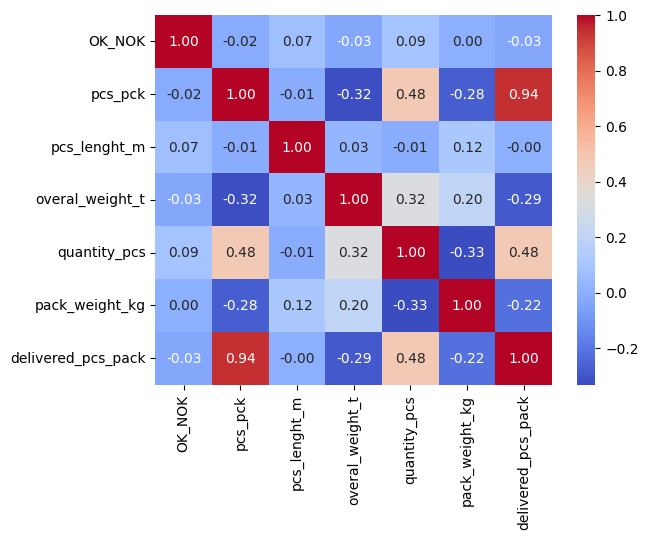

In [1326]:
g = sns.heatmap(modified_df[["OK_NOK","pcs_pck", "pcs_lenght_m", "overal_weight_t", "quantity_pcs","pack_weight_kg","delivered_pcs_pack"]].corr(),annot=True, fmt = ".2f", cmap = "coolwarm")

**Comment**: While it appears that no feature exhibits a significant linear correlation with the target feature, it's important to note that this doesn't render the features useless. Subgroups within these features may still exhibit correlations with survival rates. To ascertain this, a detailed exploration of these features is necessary. Additionally, it's observed that 'pcs_pck' and 'delivered_pcs_pack' are nearly identical, suggesting redundancy. It may be advisable to remove one of them to streamline the dataset.


In [1327]:
modified_df.drop('delivered_pcs_pack', axis=1, inplace=True)

**pcs_pck**

In [1328]:
modified_df['pcs_pck'].value_counts()

pcs_pck
40.00     2943
20.00     1590
100.00     559
60.00      343
10.00      315
25.00       35
50.00       33
80.00        5
Name: count, dtype: int64

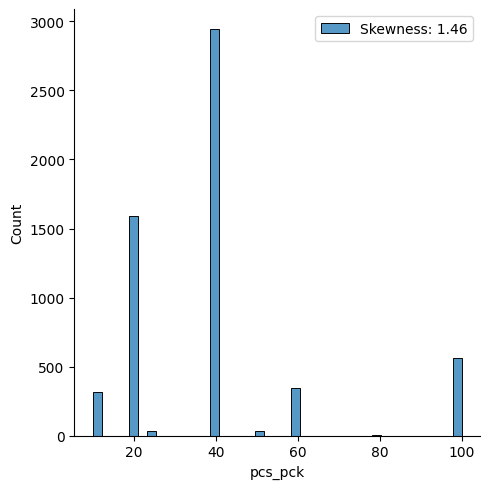

In [1329]:
sns.displot(data=modified_df, x='pcs_pck', kind='hist', label='Skewness: %.2f'%(modified_df['pcs_pck'].skew()))
plt.legend(loc='best')
plt.show()

In [1330]:
pcs_pck_vc = modified_df['pcs_pck'].value_counts()
filtered_pcs_pck_vc = pcs_pck_vc[pcs_pck_vc<300]
filtered_pcs_pck_vc

pcs_pck
25.00    35
50.00    33
80.00     5
Name: count, dtype: int64

**Comment** : The 'pcs_pck' numerical feature displays imbalance, skewness, and potentially large value ranges, which might impact predictive model performance. To tackle these issues, scaling the feature can help normalize its distribution and mitigate the influence of its skewed nature. Additionally, discretizing the feature into categorical bins offers an alternative method to address these challenges, potentially capturing non-linear patterns and reducing sensitivity to outliers.

In [1331]:
modified_df['pcs_pck'] = modified_df['pcs_pck'].apply(lambda x: np.log(x) if x > 0 else 0)

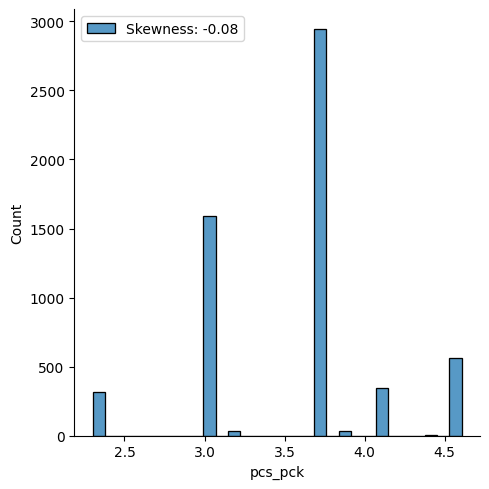

In [1332]:
sns.displot(data=modified_df, x='pcs_pck', kind='hist', label='Skewness: %.2f'%(modified_df['pcs_pck'].skew()))
plt.legend(loc='best')
plt.show()

In [1333]:
from sklearn.preprocessing import MinMaxScaler

pcs_pck_scaler = MinMaxScaler()

reshaped_pcs_pck = modified_df['pcs_pck'].values.reshape(-1,1)
modified_df['pcs_pck'] = pcs_pck_scaler.fit_transform(reshaped_pcs_pck)


**Comment** Add bins feature

In [1334]:
 # modified_df['pcs_pck_bin'] =  modified_df['pcs_pck'].apply(lambda x: 'Other_pcs_pck' if x in filtered_pcs_pck_vc else str(x))

In [1335]:
# modified_df[['pcs_pck_bin', 'OK_NOK']].groupby('pcs_pck_bin', as_index=False).mean().sort_values('OK_NOK', ascending=False)

In [1336]:
# Create the plot
# sns.catplot(x='pcs_pck_bin', y='OK_NOK', data=modified_df, kind="bar", height=6, palette="muted")
# plt.show()

**pcs_lenght_m**

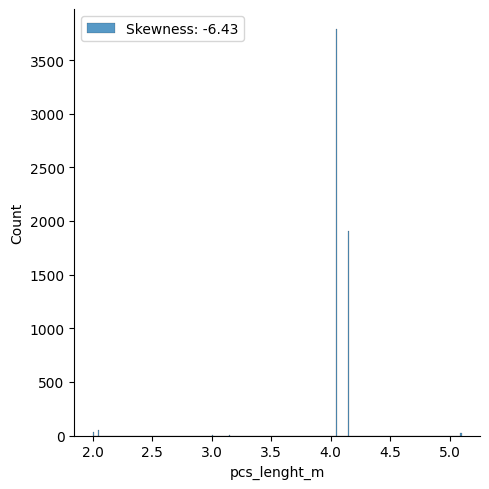

In [1337]:
sns.displot(data=modified_df, x='pcs_lenght_m', kind='hist', label='Skewness: %.2f'%(modified_df['pcs_lenght_m'].skew()))
plt.legend(loc='best')
plt.show()

**Comment** From distribiution plot we can see that pcs_lenght_m column has 2 dominant values and therefore is more categorical than numerical feature.

In [1338]:
pcs_lenght_m_vc = modified_df['pcs_lenght_m'].value_counts()
filterd_pcs_lenght_m_vc = pcs_lenght_m_vc[pcs_lenght_m_vc<1000]
pcs_lenght_m_vc

pcs_lenght_m
4.05    3786
4.15    1911
2.05      56
2.00      33
5.10      21
3.15      10
3.00       6
Name: count, dtype: int64

In [1339]:
 modified_df['pcs_lenght_m_bin'] =  modified_df['pcs_lenght_m'].apply(lambda x: 'Other_lenght' if x in filterd_pcs_lenght_m_vc else str(x))

In [1340]:
 modified_df['pcs_lenght_m_bin'].value_counts()

pcs_lenght_m_bin
4.05            3786
4.15            1911
Other_lenght     126
Name: count, dtype: int64

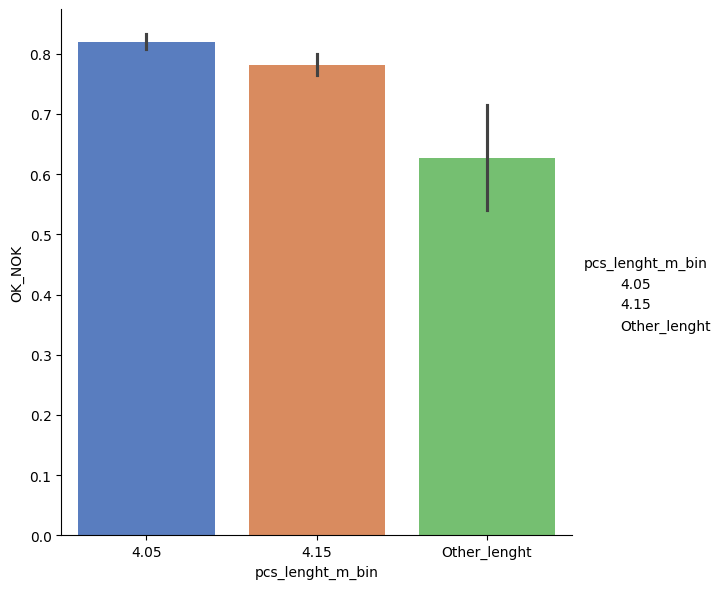

In [1341]:
sns.catplot(x='pcs_lenght_m_bin', y='OK_NOK', data=modified_df, kind="bar", height=6, palette="muted")
plt.show()

In [1342]:
modified_df.drop('pcs_lenght_m', axis=1, inplace=True)
modified_df.reset_index(drop=True, inplace=True)

In [1343]:
modified_df = pd.get_dummies(modified_df, columns=['pcs_lenght_m_bin'], prefix='pLEN')

**overal_weight_kg**

**Comment** It seems that using median values for NaN in quantities column has caused some outliers to crop up in the 'overal_weight_kg' column for heavier profiles. I'm planning to filter out these outliers and recalculate the median weight without them. Then, I'll use this adjusted median value for those outliers.

In [1344]:
weight_vc = modified_df['overal_weight_t'].value_counts()
weight_vc[weight_vc.index>1.5]

overal_weight_t
1.75    50
1.61    43
1.60    21
1.81    14
2.68     7
2.73     3
Name: count, dtype: int64

In [1345]:
filtered_weight_vc = weight_vc[weight_vc.index<1.5]
median_overal_weight_t = modified_df.loc[modified_df['overal_weight_t'].isin(filtered_weight_vc.index), 'overal_weight_t'].median()
filtered_weight_vc_less_1_5 = filtered_weight_vc = weight_vc[weight_vc.index>1.5]

In [1346]:
# modified_df[modified_df['overal_weight_t'].isin(filtered_weight_vc.index)]
modified_df.loc[modified_df['overal_weight_t'].isin(filtered_weight_vc_less_1_5.index), 'overal_weight_t'] = median_overal_weight_t

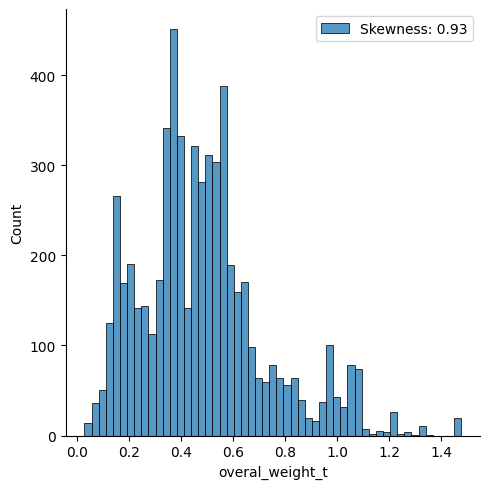

In [1347]:
sns.displot(data=modified_df, x='overal_weight_t', kind='hist', label='Skewness: %.2f'%(modified_df['overal_weight_t'].skew()))
plt.legend(loc='best')
plt.show()

In [1348]:
modified_df['overal_weight_t'] = modified_df['overal_weight_t'].apply(lambda x: np.log(x) if x > 0 else 0)

**Comment** Next we add bins feature

In [1349]:
# modified_df['overal_weight_t'].value_counts()

In [1350]:
# modified_df['overal_weight_t_bin'] = pd.cut(modified_df['overal_weight_t'], bins=5)

In [1351]:
# sns.catplot(x='overal_weight_t_bin', y='OK_NOK', data=modified_df, kind="bar", height=6, palette="muted")

**quantity_pcs**

In [1352]:
modified_df['quantity_pcs'].value_counts()

quantity_pcs
574.50     1864
600.00      113
360.00       86
400.00       78
1200.00      77
           ... 
595.00        1
1181.00       1
1096.00       1
1489.00       1
2032.00       1
Name: count, Length: 897, dtype: int64

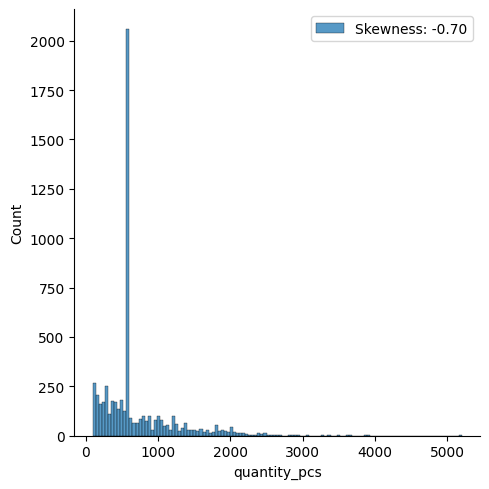

In [1353]:
sns.displot(data=modified_df, x='quantity_pcs', kind='hist', label='Skewness: %.2f'%(modified_df['overal_weight_t'].skew()))
plt.legend(loc='best')
plt.show()

**Comment** Quantity is better represented as categorical feature.

In [1354]:
modified_df['quantity_pcs_bin'] = pd.cut(modified_df['quantity_pcs'], bins=5)

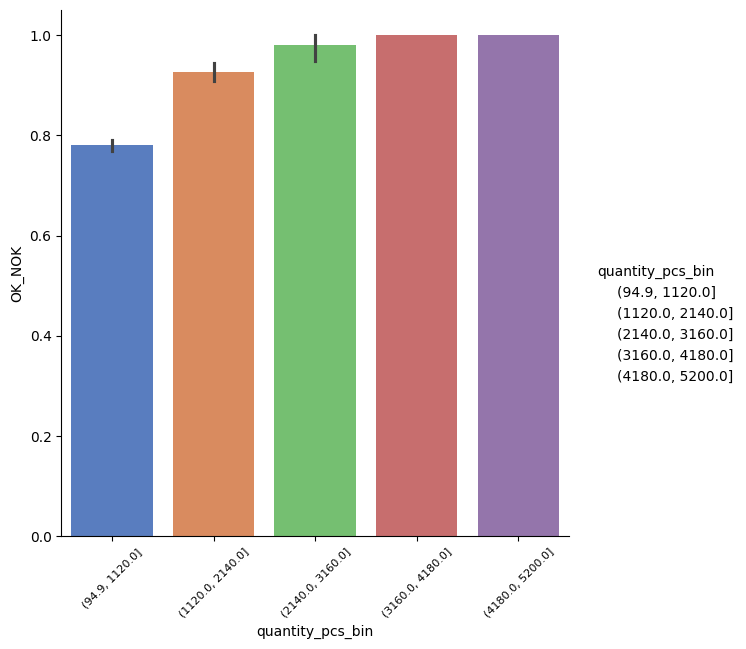

In [1355]:
quantity_bin_plot = sns.catplot(x='quantity_pcs_bin', y='OK_NOK', data=modified_df, kind="bar", height=6, palette="muted")
quantity_bin_plot.set_xticklabels(rotation=45, fontsize=8)
plt.show()

In [1356]:
modified_df.drop('quantity_pcs', axis=1, inplace=True)
modified_df.reset_index(drop=True, inplace=True)

In [1357]:
modified_df = pd.get_dummies(modified_df, columns=['quantity_pcs_bin'], prefix='QUA')

**pack_weight_kg**

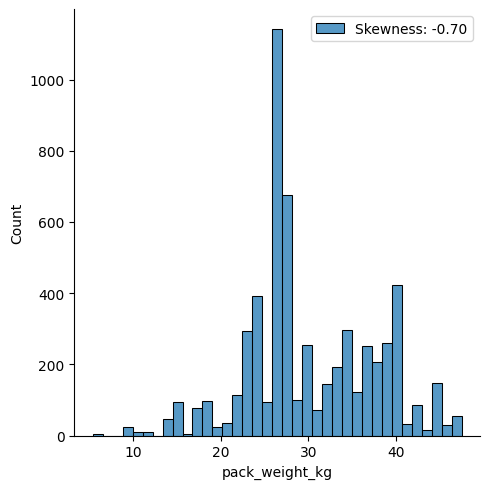

In [1358]:
sns.displot(data=modified_df, x='pack_weight_kg', kind='hist', label='Skewness: %.2f'%(modified_df['overal_weight_t'].skew()))
plt.legend(loc='best')
plt.show()


In [1359]:
modified_df['pack_weight_kg'] = modified_df['pack_weight_kg'].apply(lambda x: np.log(x) if x > 0 else 0)


In [1360]:
pcs_pck_scaler = MinMaxScaler()

reshaped_pcs_pck = modified_df['pack_weight_kg'].values.reshape(-1,1)
modified_df['pack_weight_kg'] = pcs_pck_scaler.fit_transform(reshaped_pcs_pck)

**Comment** Add bin feature

In [1361]:
# modified_df['pack_weight_kg_bin'] = pd.cut(modified_df['pack_weight_kg'], bins=10)

In [1362]:
# pack_weight_bin_vc = modified_df['pack_weight_kg_bin'].value_counts()
# filtered_pack_weight_bin_vc = pack_weight_bin_vc[pack_weight_bin_vc<200]

In [1363]:
# modified_df['pack_weight_kg_bin'] =  modified_df['pack_weight_kg_bin'].apply(lambda x: 'Other_pack_weight' if x in filtered_pack_weight_bin_vc else str(x))

In [1364]:
 # modified_df['pack_weight_kg_bin'].value_counts()

In [1365]:
# pack_weight_bin_plot = sns.catplot(x='pack_weight_kg_bin', y='OK_NOK', data=modified_df, kind="bar", height=6, palette="muted")
# pack_weight_bin_plot.set_xticklabels(rotation=45, fontsize=8)
# plt.show()

### 5.2 Categorical features
    *name
    *shape_no
    *drawing_no
    *surface_finish
    *supplier
    
    


**name**

In [1366]:
name_vc = modified_df['name'].value_counts()
name_vc

name
Phecda         522
Procyon        458
Regor          421
Centauri       135
Telescopium    120
              ... 
Stardust         5
Altair           5
Sculptor         5
Indus            5
Coma             5
Name: count, Length: 154, dtype: int64

In [1367]:
name_prob_ok_nok = modified_df.groupby('name')['OK_NOK'].mean()
name_order = name_prob_ok_nok.sort_values().index

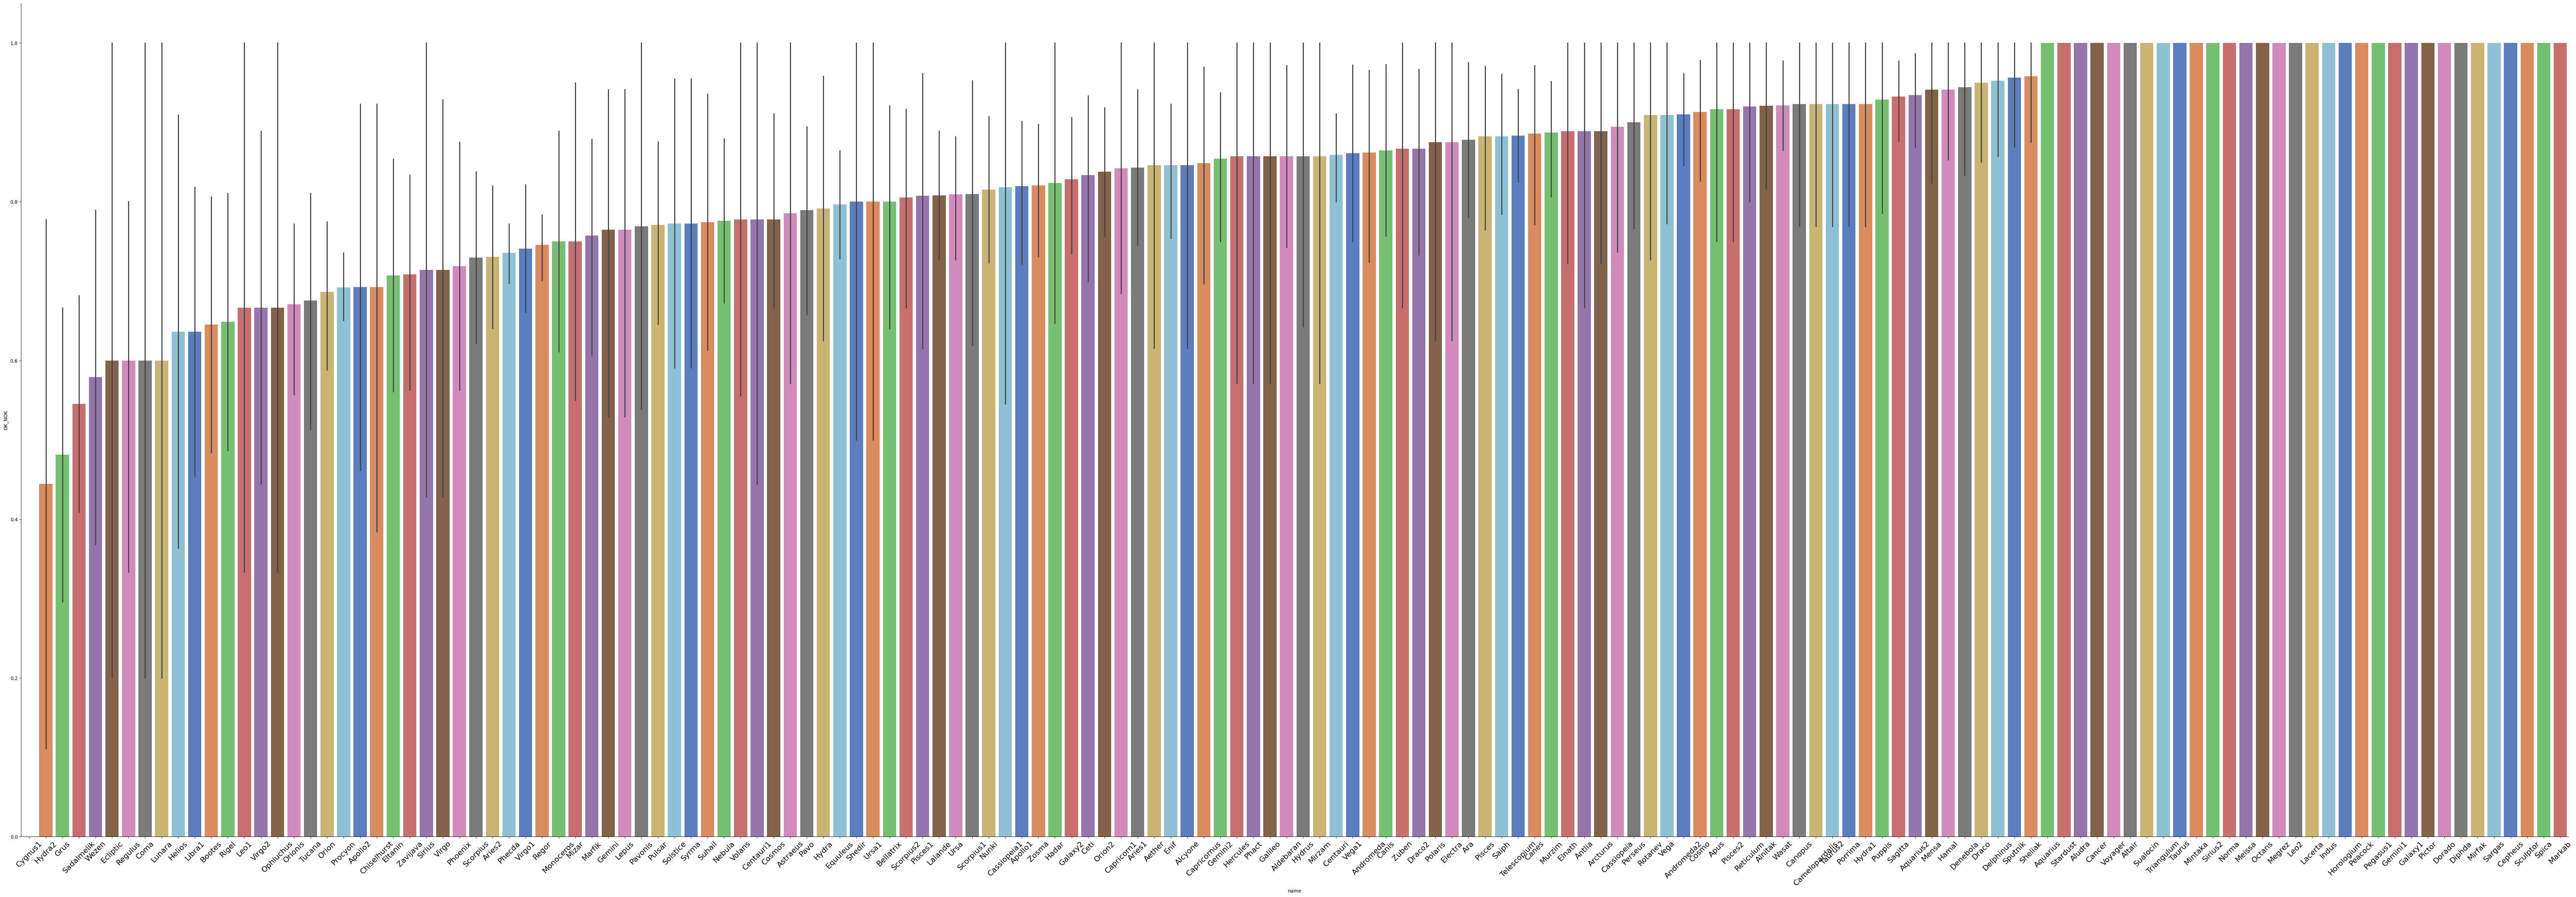

In [1368]:
name_plot = sns.catplot(x='name', y='OK_NOK', data=modified_df, kind="bar", height=25, aspect=3, palette="muted", order=name_order, legend=False)
name_plot.set_xticklabels(rotation=45, fontsize=16)
plt.show()

In [1369]:
pivot_table = modified_df.pivot_table(index='name', values='OK_NOK', aggfunc='mean')

# Display the pivot table
pivot_table.sort_values(by='OK_NOK', ascending=False)

,OK_NOK
name,
Megrez,1.00
Spica,1.00
Sculptor,1.00
Sargas,1.00
Cepheus,1.00
...,...
Wezen,0.58
Sadalmelik,0.55
Grus,0.48


**shape_no**

In [1370]:
shape_no_vc = modified_df['shape_no'].value_counts()
# filtered_shape_no_vc_35 = shape_no_vc[shape_no_vc<=35]
shape_no_vc

shape_no
SH5      655
SH1      570
SH0      549
SH39     272
SH15     242
        ... 
SH26       5
SH70       5
SH103      5
SH104      5
SH107      5
Name: count, Length: 70, dtype: int64

In [1371]:
# modified_df['shape_no_bin'] = modified_df['shape_no'].apply(lambda x:'less_35_shape_no' if x in filtered_shape_no_vc_35 else str(x))
# modified_df['shape_no_bin'] = modified_df['shape_no'].apply(lambda x: 
#                             'less_25_shape_no' if x in filtered_shape_no_vc_35
#                             else ('less_75_shape_no' if x in filtered_shape_no_vc_75
#                             else ('less_100_shape_no' if x in filtered_shape_no_vc_100 else str(x))))

In [1372]:
shape_no_prob_ok_nok = modified_df.groupby('shape_no')['OK_NOK'].mean()
shape_no_order = shape_no_prob_ok_nok.sort_values().index

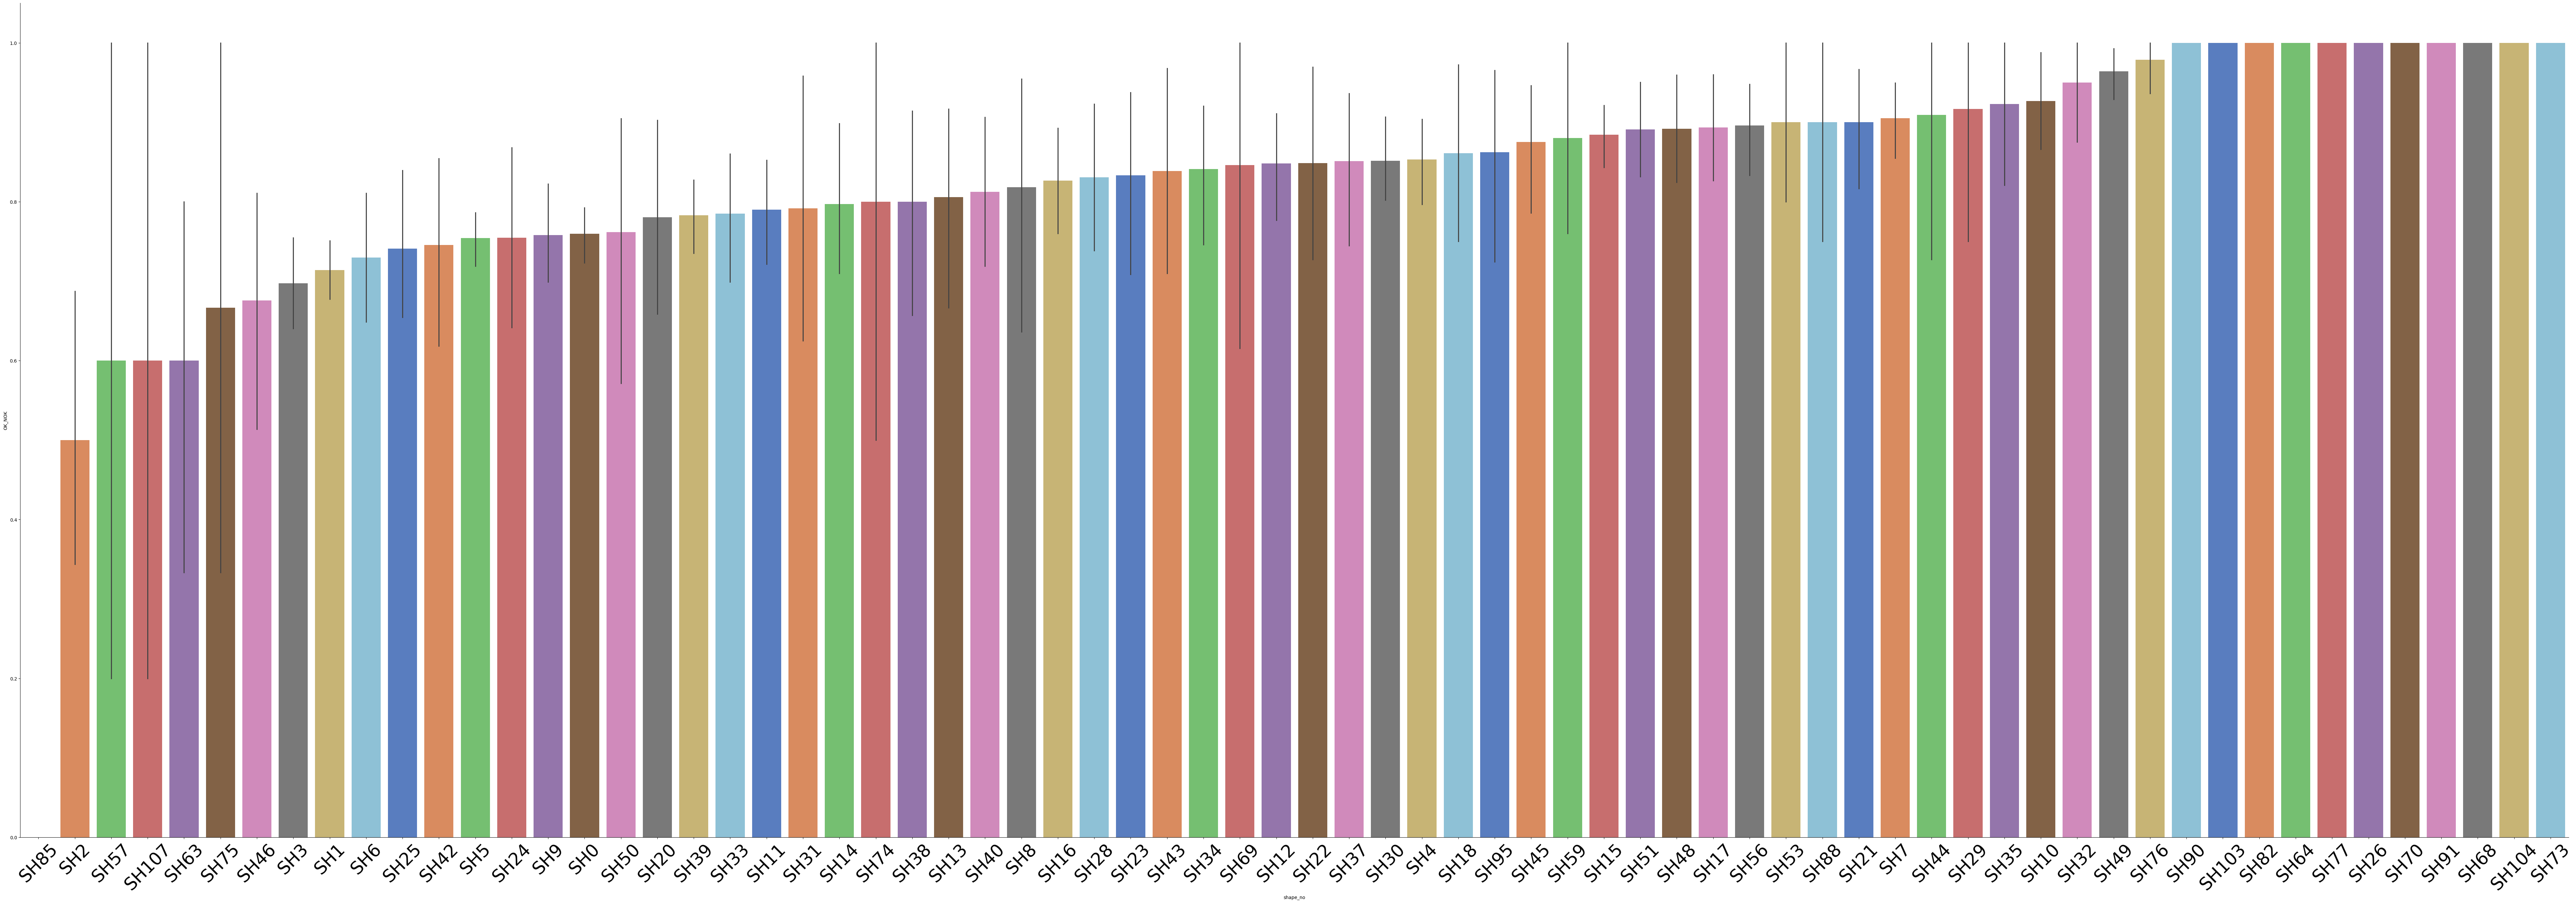

In [1373]:
shape_no_plot = sns.catplot(x='shape_no', y='OK_NOK', data=modified_df, kind="bar", height=26, aspect=3, palette="muted", order=shape_no_order, legend=False)
shape_no_plot.set_xticklabels(rotation=45, fontsize=38)
plt.show()

**drawing_no**

In [1374]:
drawing_no_vc = modified_df['drawing_no'].value_counts()
drawing_no_vc

drawing_no
DR5      338
DR1      296
DR10     293
DR0      283
DR20     269
        ... 
DR64       5
DR79       5
DR80       5
DR83       5
DR170      5
Name: count, Length: 106, dtype: int64

In [1375]:
drawing_no_prob_ok_nok = modified_df.groupby('drawing_no')['OK_NOK'].mean()
drawing_no_order = drawing_no_prob_ok_nok.sort_values().index

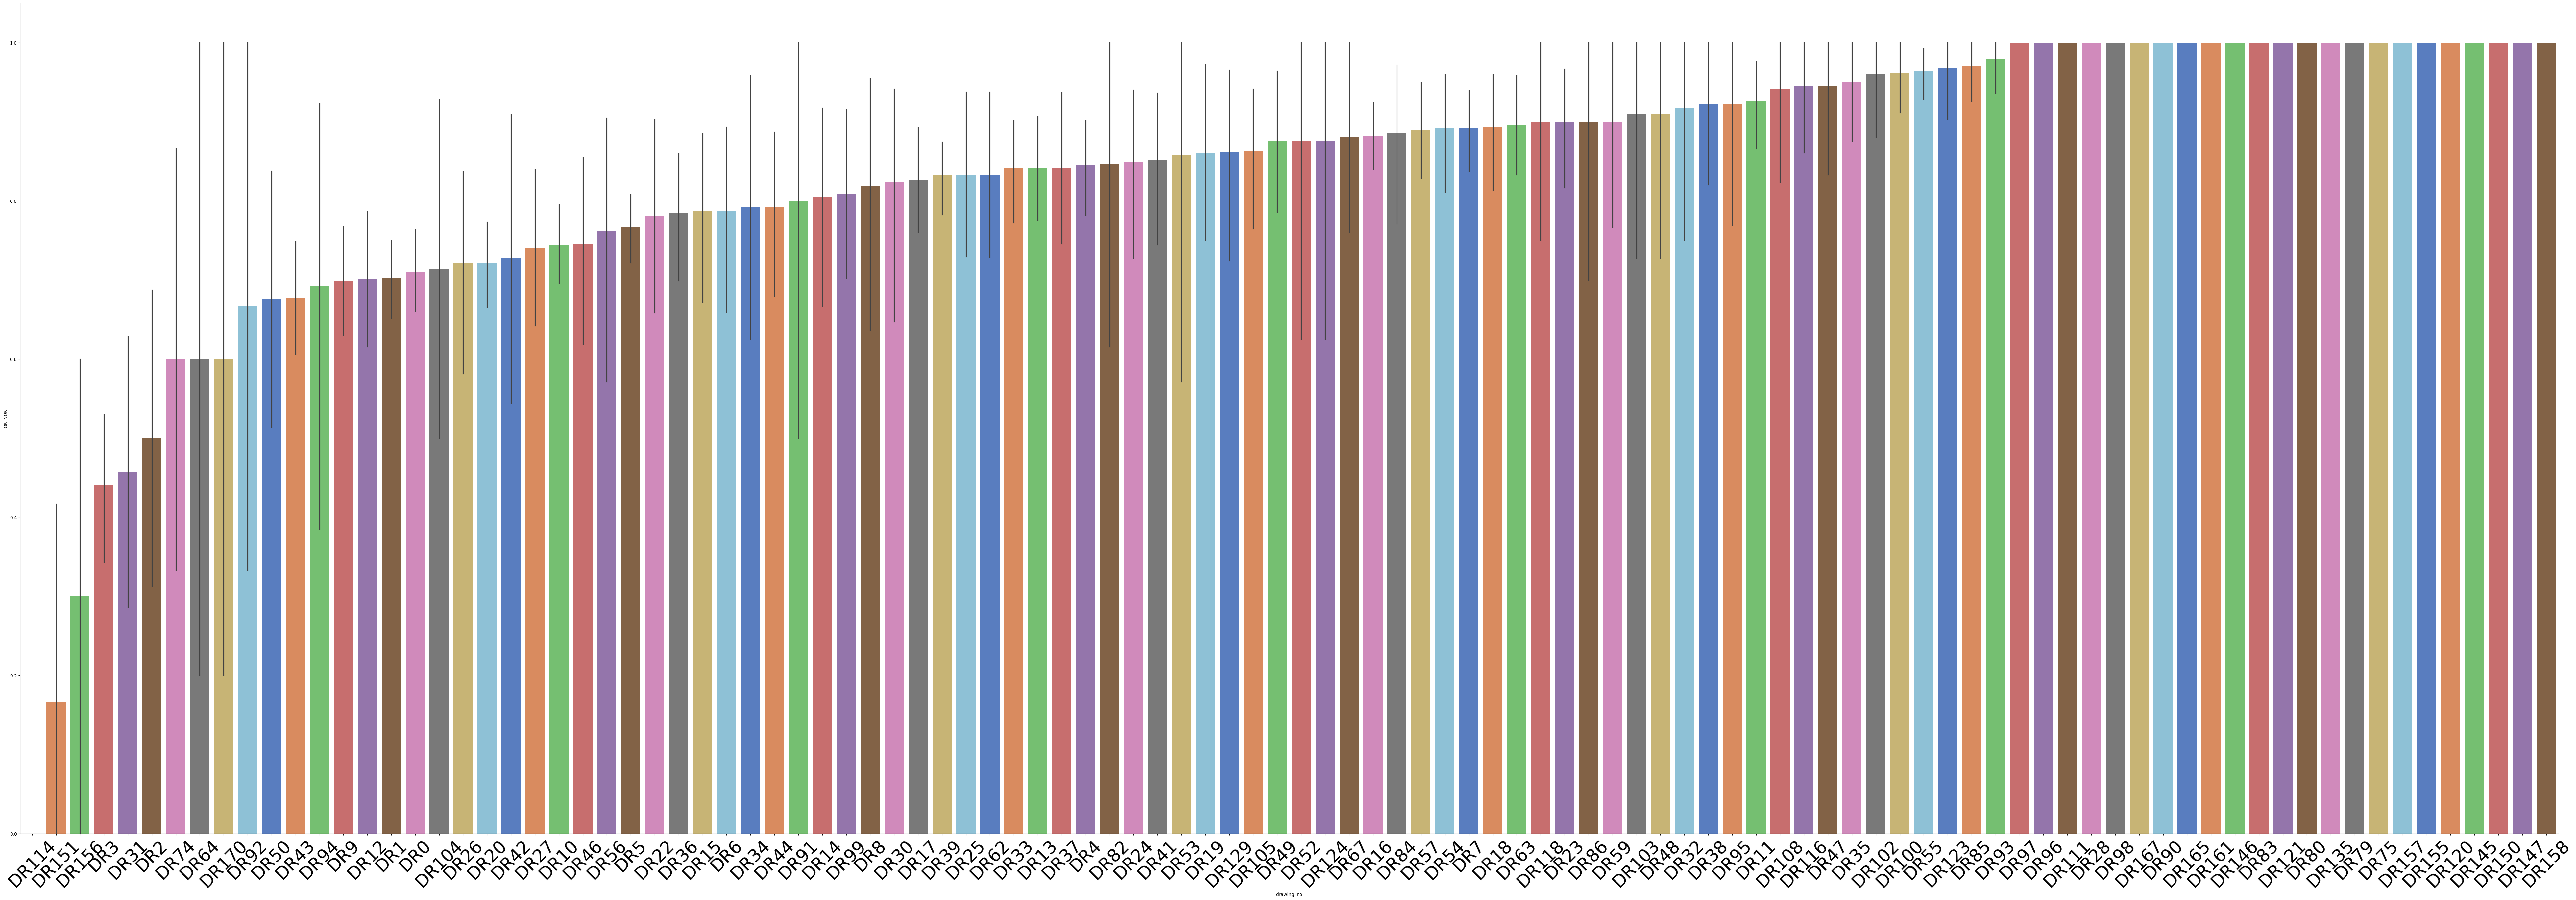

In [1376]:
drawing_no_order_plot = sns.catplot(x='drawing_no', y='OK_NOK', data=modified_df, kind="bar", height=26, aspect=3, palette="muted", order=drawing_no_order, legend=False)
drawing_no_order_plot.set_xticklabels(rotation=45, fontsize=38)
plt.show()

**surface_finish**

In [1377]:
surface_finish_vc = modified_df['surface_finish'].value_counts()
surface_finish_vc

surface_finish
C-0      3679
SUR      1521
C-35      617
BIAŁY       6
Name: count, dtype: int64

In [1378]:
modified_df = modified_df[modified_df['surface_finish'] != "BIAŁY"]

In [1379]:
surface_finish_prob_ok_nok = modified_df.groupby('surface_finish')['OK_NOK'].mean()
surface_finish_order = surface_finish_prob_ok_nok.sort_values().index

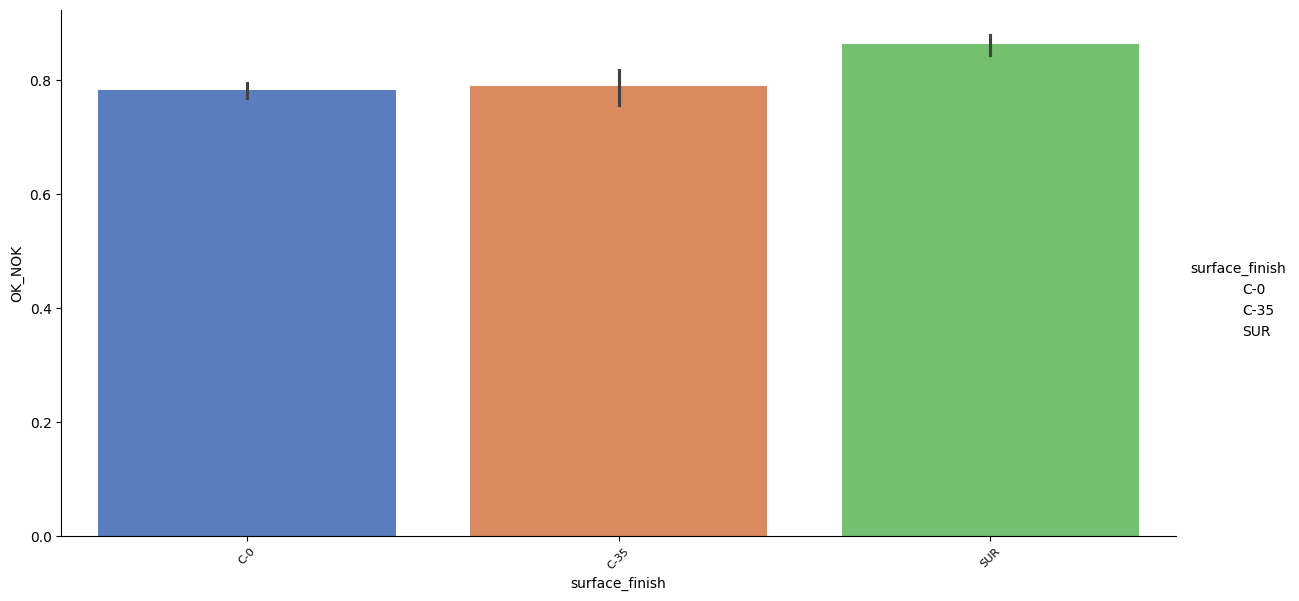

In [1380]:
surface_finish_plot = sns.catplot(x='surface_finish', y='OK_NOK', data=modified_df, kind="bar", height=6, aspect=2, palette="muted", order=surface_finish_order,)
surface_finish_plot.set_xticklabels(rotation=45, fontsize=8)
plt.show()

**supplier**

In [1381]:
supplier_vc = modified_df['supplier'].value_counts()
supplier_vc

supplier
SU1    4007
SU0    1613
SU2     136
SU5      25
SU3      15
SU6      12
SU4       9
Name: count, dtype: int64

In [1382]:
supplier_prob_ok_nok = modified_df.groupby('supplier')['OK_NOK'].mean()
supplier_order = supplier_prob_ok_nok.sort_values().index

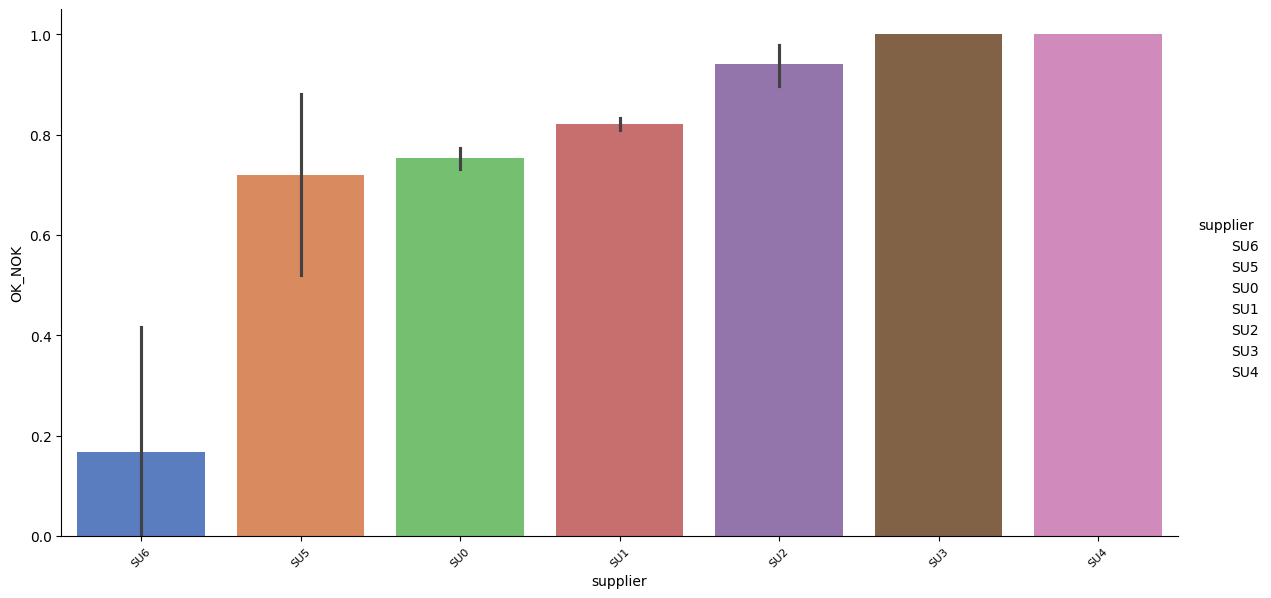

In [1383]:
supplier_plot = sns.catplot(x='supplier', y='OK_NOK', data=modified_df, kind="bar", height=6, aspect=2, palette="muted", order=supplier_order,)
supplier_plot.set_xticklabels(rotation=45, fontsize=8)
plt.show()

In [1384]:
x = ['name','shape_no','drawing_no','surface_finish','supplier']
modified_df = pd.get_dummies(modified_df, columns=x)

In [1389]:
modified_df.head(2)

,OK_NOK,date_fmt,pcs_pck,pack_weight_kg,overal_weight_t,pLEN_4.05,pLEN_4.15,pLEN_Other_lenght,"QUA_(94.9, 1120.0]","QUA_(1120.0, 2140.0]",...,surface_finish_C-0,surface_finish_C-35,surface_finish_SUR,supplier_SU0,supplier_SU1,supplier_SU2,supplier_SU3,supplier_SU4,supplier_SU5,supplier_SU6
0,0,2017-01-13,0.60,0.68,-1.08,True,False,False,True,False,...,True,False,False,True,False,False,False,False,False,False
1,0,2017-01-13,0.60,0.92,-0.56,False,True,False,True,False,...,True,False,False,True,False,False,False,False,False,False


In [1386]:
modified_df.to_csv('to_modeling_dataframe.csv', index=False)



In [1387]:
dtype = {'date_fmt': 'datetime64[ns]'}
to_modeling_df = pd.read_csv('to_modeling_dataframe.csv', parse_dates=['date_fmt'])


### 6. Modeling
    